In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1012. Allostatic Load/P1012.3. Analyses/P1012.3.2. Ordinal Regression/Output')
cur_date = "060624"

library(readxl)
library(openxlsx)
library(tidyverse)
library(ordinalNet)
library(reshape2)
library(ggpubr)

# reading in file
bp_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_050824.xlsx", sheet = 4)) 
subject_info_df = data.frame(read_excel("Input/Subject_Info_050824.xlsx", sheet = 2))
mediator_scores_df = data.frame(read_excel("Input/Mediator_Scores_BP_Subjects_060324.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
head(bp_df)
head(subject_info_df)
head(mediator_scores_df)

,Subject_ID,Systolic,Diastolic,BP_Classification
,<chr>,<dbl>,<dbl>,<chr>
1,CS_M_21_W_5,114,70,N
2,CS_M_24_W_8,118,71,N
3,CS_M_25_W_10,121,83,E
4,CS_M_28_W_16,115,74,N
5,CS_M_29_W_17,118,80,N
6,CS_F_31_B_21,112,77,N


,Study,Original_Subject_Number,Subject_ID,Subject_Number,Smoking_Status,Sex,Age,Race
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,FM2,97,CS_M_18_B_1,1,CS,M,18,B
2,FM2,99,CS_F_20_W_2,2,CS,F,20,W
3,FM2,101,CS_F_20_W_3,3,CS,F,20,W
4,FM2,98,CS_F_21_W_4,4,CS,F,21,W
5,TCORS LAIV,39,CS_M_21_W_5,5,CS,M,21,W
6,FM2,100,CS_F_22_W_6,6,CS,F,22,W


,Variable,Subject_ID,Mediator_Score,Smoking_Status,Race
,<chr>,<chr>,<dbl>,<chr>,<chr>
1,Cortisol,CS_M_21_W_5,0.24743096,NA,NA
2,Cortisol,CS_M_24_W_8,0.31083055,NA,NA
3,Cortisol,CS_M_25_W_10,0.13144609,NA,NA
4,Cortisol,CS_M_28_W_16,0.06754252,NA,NA
5,Cortisol,CS_M_29_W_17,0.44649218,NA,NA
6,Cortisol,CS_F_31_B_21,0.21687581,NA,NA


In this analysis, we're using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 18 biomarkers. 

Starting by combining the dataframes.

In [3]:
# splitting the df based on group and race, to make the code more efficient
split_mediator_df = mediator_scores_df %>%
    group_by(Smoking_Status, Race) %>%
    # splitting the df based on those variables
    group_split()

no_covariates_df = split_mediator_df[[4]]

In [4]:
# creating a vector for variables that increase atherosclerotic risk
# HDL decreases risk
allostatic_load_biomarkers = c('Cortisol','Noradrenaline','Epinephrine','Hba1c','Fibrinogen','CRP', 'HDL')

ordinal_regression = function(dataset){
    # add words!!!!!
    # creating 1 df
    ordinal_regression_df = inner_join(bp_df[,c(1,4)], subject_info_df[,3:8]) %>%
        # adding mediator scores data
        inner_join(dataset[,1:3]) %>%
        # obtaining allostatic load biomarkers only
        filter(Variable %in% allostatic_load_biomarkers) %>%
        pivot_wider(names_from = Variable, values_from = Mediator_Score)
    
    # turning BP into a factor
    ordinal_regression_df$BP_Classification = factor(ordinal_regression_df$BP_Classification, levels = c("N", "E", "1", '2'))

    #reordering and removing some columns
    ordinal_regression_df = ordinal_regression_df[,c(1,8:14,2)]

    return(ordinal_regression_df)
    }

# calling fn
reg_df = ordinal_regression(no_covariates_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


In [5]:
# creating a vector of booleans that specifies whether or not the coefficient should be
# positive (TRUE) or negative (FALSE), only HDL will be negative
biomarker_coefficients = c(rep(TRUE, ncol(reg_df) - 2))

estimateOrdWeights <- function(dataset, response, coefficients_magnitude){
    # """
    # Creating a function to run ordinal regression to estimate ordinal weights of mediator data based
    # on blood pressure classification
    # :param (input): wide df with biomarker data, response variable, magnitude of the coefficients
    # :output: 1 df with the ordinal weights
    # """
    
    # setting seed for reproducibility
    set.seed(12)
    
    #get number of response levels
    NoBins <- length(unique(dataset[[response]]))

    #get number of features or slices
    noSlices <- ncol(dataset) - 2

    # HDL needs to be negative so we'll make all the values negative
    dataset$HDL = dataset$HDL * -1
    
    # obtaining the features and converting into a matrix
    feature_data <- as.matrix(dataset[,c(2:(ncol(dataset) - 1))])

    # ordinal regression
    # positiveID specifies whether or not each coefficient for each ind. variable should be constrained to be non-negative
    regression_model <- ordinalNet(feature_data, dataset[[response]], positiveID = coefficients_magnitude, 
                            # lambdaVals defines how quickly your coefficients drop to 0
                            # keeping it at 0 tries to minimize feature reduction
                            # maxiterout defines the number of iterations before it stops
                         lambdaVals = 0, maxiterOut = 150)
    testW <- regression_model$coefs[NoBins:(noSlices + NoBins - 1)]

    # rescaling the coefficients so that they sum to 1
    normalizer = 1/sum(testW)
    rescaled_weight <- testW * normalizer

    # adding the variable names back in 
    test_weights_df = data.frame(Variable = colnames(feature_data), Coefficient = rescaled_weight) %>%
        arrange(-Coefficient) 
    
    return(test_weights_df)
}

# calling fn
weights_df = estimateOrdWeights(reg_df, 'BP_Classification', biomarker_coefficients)

weights_df

Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.55594942
Fibrinogen,0.25770925
Noradrenaline,0.15662389
Cortisol,0.02971744
Hba1c,0.00000000
CRP,0.00000000
HDL,0.00000000


Based on the overall results with all 34 subjects, we can see that epinephrine had the largest (56%) contribution to blood pressure classification, while 3 variables were constrained to 0 having no impact on BP classification.

# Allostatic Load Summation

Now that we have these weights from the ordinal regression, we'll calculate allostatic load scores for each subject using both the previously calculated mediator scores multiplied the ordinal weight for the 7 allostatic load biomarkers (cortisol, noradrenaline, epinephrine, HDL, Hba1c, fibrinogen, and CRP). The formula looks like...

Allostatic Load = Cortisol ordinal weight * Cortisol score + CRP ordinal weight * CRP score...

In [6]:
allostatic_load = function(mediator_scores_df){
    # add words!!
    
    # combining the mediator scores with the ordinal weights into one dataframe
    wider_weights_df = dcast(mediator_scores_df, Variable ~ Subject_ID, value.var = "Mediator_Score") %>% 
        inner_join(weights_df) %>%
        column_to_rownames("Variable")

    # multiplying the value of the mediator in each row by its respective ordinal
    # weight found in the last column
    multiplication_df = wider_weights_df %>%
        select(-Coefficient) %>%
        mutate(across(contains("_"), ~.x*wider_weights_df$Coefficient))

    # calculating allostatic load by summing by the columns
    allostatic_load_df = data.frame(Allostatic_Load = apply(multiplication_df, 2, sum)) %>%
        arrange(-Allostatic_Load) %>%
        rownames_to_column(var = "Subject_ID")
    
    return(allostatic_load_df)
    }

# calling fn
allostatic_df = allostatic_load(no_covariates_df)

head(allostatic_df)

Joining with `by = join_by(Variable)`


,Subject_ID,Allostatic_Load
,<chr>,<dbl>
1,NS_F_27_B_50,0.6464005
2,CS_M_28_W_16,0.6365527
3,NS_F_23_W_41,0.6262244
4,NS_F_38_B_61,0.6007436
5,NS_F_32_B_57,0.5484291
6,NS_F_21_B_37,0.5341852


Now testing for statistical differences based on sex and smoking status using a two way anova.

In [10]:
# adding in demographic info for each subject
anova_df = inner_join(allostatic_df, subject_info_df[,c(3,5,6,8)])
head(anova_df)

# looking at counts for each variable
table(anova_df[,c(3,5)])

Joining with `by = join_by(Subject_ID)`


,Subject_ID,Allostatic_Load,Smoking_Status,Sex,Race
,<chr>,<dbl>,<chr>,<chr>,<chr>
1,NS_F_27_B_50,0.6464005,NS,F,B
2,CS_M_28_W_16,0.6365527,CS,M,W
3,NS_F_23_W_41,0.6262244,NS,F,W
4,NS_F_38_B_61,0.6007436,NS,F,B
5,NS_F_32_B_57,0.5484291,NS,F,B
6,NS_F_21_B_37,0.5341852,NS,F,B


              Race
Smoking_Status  B  W
            CS  8  9
            NS 11  6

In [12]:
# two way anova
anova = aov(Allostatic_Load ~ Smoking_Status * Race, data = test)

summary(anova)

                    Df Sum Sq Mean Sq F value Pr(>F)
Smoking_Status       1 0.0700 0.06999   2.713  0.110
Race                 1 0.0033 0.00331   0.128  0.723
Smoking_Status:Race  1 0.0517 0.05168   2.003  0.167
Residuals           30 0.7740 0.02580               

In [13]:
# post hoc
TukeyHSD(anova)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Allostatic_Load ~ Smoking_Status * Race, data = test)

$Smoking_Status
            diff         lwr       upr     p adj
NS-CS 0.09074047 -0.02177559 0.2032565 0.1099898

$Race
          diff         lwr       upr     p adj
W-B 0.01955001 -0.09375289 0.1328529 0.7270119

$`Smoking_Status:Race`
                  diff         lwr       upr     p adj
NS:B-CS:B  0.164159922 -0.03878232 0.3671022 0.1465005
CS:W-CS:B  0.096580778 -0.11564357 0.3088051 0.6085870
NS:W-CS:B  0.101009321 -0.13486486 0.3368835 0.6533612
CS:W-NS:B -0.067579144 -0.26388552 0.1287272 0.7858285
NS:W-NS:B -0.063150602 -0.28481171 0.1585105 0.8652566
NS:W-CS:W  0.004428543 -0.22576108 0.2346182 0.9999474


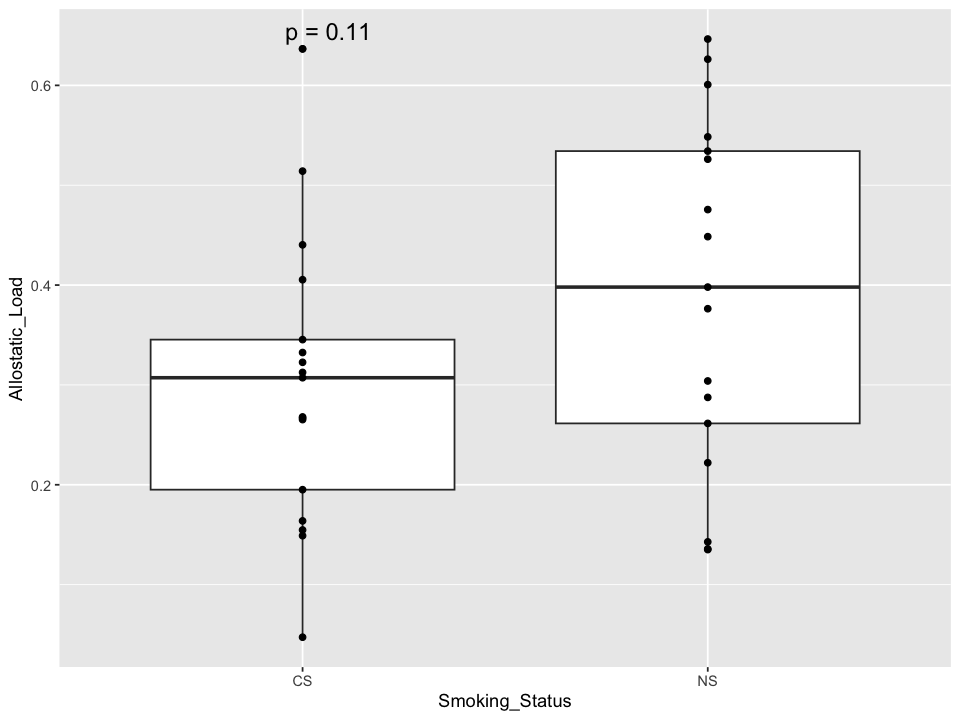

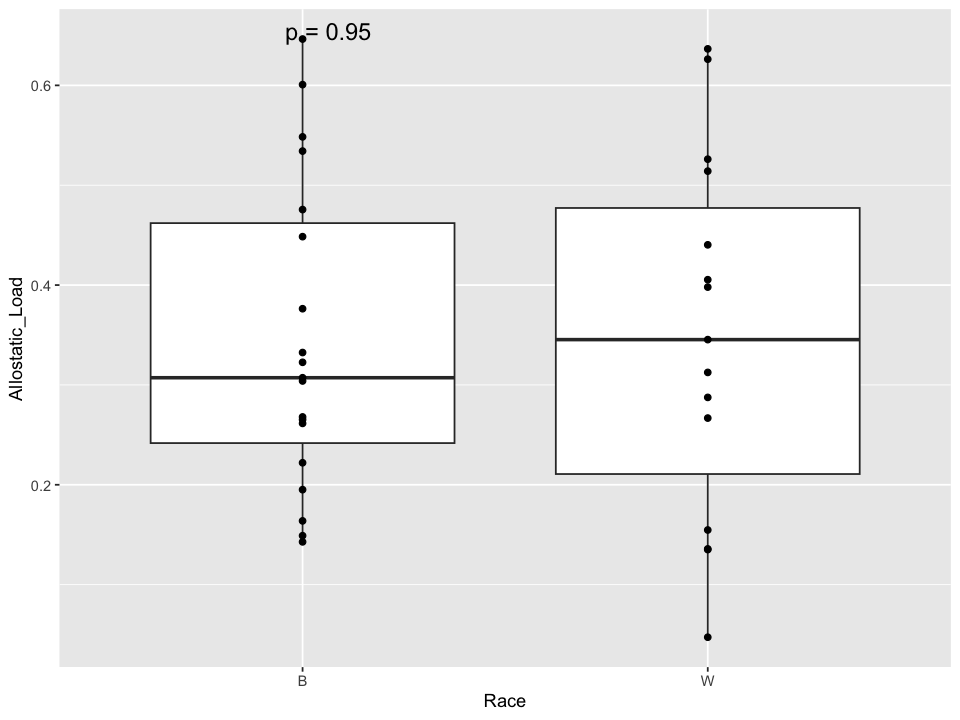

In [20]:
# visualizing using boxplots
options(repr.plot.width=8, repr.plot.height=6) #changing size

ggplot(data = anova_df, aes(y = Allostatic_Load, x = Smoking_Status)) + 
  geom_boxplot() +
  geom_point() + 

 stat_anova_test(wid = "Smoking_Status", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 5)

ggplot(data = anova_df, aes(y = Allostatic_Load, x = Race)) + 
  geom_boxplot() +
  geom_point() + 

 stat_anova_test(wid = "Race", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 5)

There are no statistically significant differences in allostatic load by smoking status (p value = 0.11), race (p value = 0.95), nor the interaction between the two variables (p value = 0.95). (Not sure why the p values for race are different in the boxplot vs. the `aov` function, but either way it's still insignificant.)